# Movie Recommendation
### Project 4 PSL542
### Abhishek Jain (661363274), Rahul Sharma (656504734)

- Initialization

In [146]:
from ctypes import kind

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [147]:
import warnings
with warnings.catch_warnings(record=True):
    movies = pd.read_table('dataset/movies.dat', sep='::', encoding='iso-8859-1',header=None, names= ['MovieID', 'Title', 'Genres'])
    ratings = pd.read_table('dataset/ratings.dat', sep='::', encoding='iso-8859-1',header=None, names= ["UserID","MovieID","Rating","Timestamp"])
    users = pd.read_table('dataset/users.dat', sep='::', encoding='iso-8859-1',header=None, names=["UserID","Gender","Age","Occupation","Zip"])

- Data Preparation

In [148]:
import re
def title_production_yr_split(title):
    groups=re.search('^(.+)\((\d+)\)$',title)
    movie_title=groups.group(1).strip()
    production_year=int(groups.group(2))
    return {"Title_1":movie_title, "Production_Year":production_year}
applied_df = movies.apply(lambda row: title_production_yr_split(row.Title), axis='columns', result_type='expand')
movies = pd.concat([movies, applied_df], axis='columns')
movies["Decade"] =movies.Production_Year//10*10
movies.head(2)

,MovieID,Title,Genres,Title_1,Production_Year,Decade
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story,1995,1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji,1995,1990


In [149]:
dummies_genres = movies['Genres'].str.get_dummies()
movies_cleaned = pd.concat([movies,dummies_genres],axis=1)
movies_cleaned.drop('Genres',inplace=True,axis=1)
total_genres=dummies_genres.columns.values
movies_cleaned.head(2)

,MovieID,Title,Title_1,Production_Year,Decade,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Toy Story,1995,1990,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Jumanji,1995,1990,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [150]:
ratings.head(2)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


In [151]:
users.head()

,UserID,Gender,Age,Occupation,Zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### Summary

In [154]:
print('Unique users:', ratings.UserID.nunique())
print('Unique movies:', ratings.MovieID.nunique())
print('Unique ratings:', ratings.Rating.unique())
print('Average rating:', round(ratings.Rating.mean(), 2))

Unique users: 6040
Unique movies: 3706
Unique ratings: [5 3 4 2 1]
Average rating: 3.58


<AxesSubplot: ylabel='Frequency'>

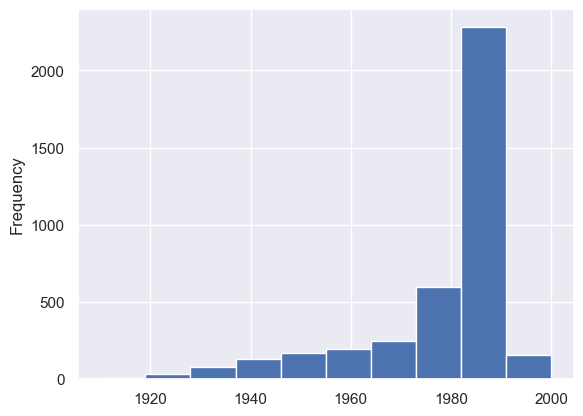

In [186]:
# Movies production count by Decades
movies_cleaned["Decade"].plot(kind="hist",bins=10)

#### Genre movies count

In [8]:
genre_total=movies_cleaned.drop(["MovieID","Title","Title_1","Production_Year",'Decade'],axis=1).sum().sort_values()

<AxesSubplot: title={'center': 'Genres Counts'}>

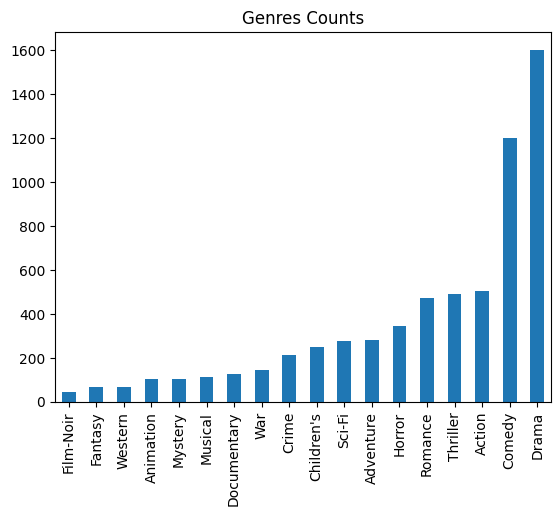

In [9]:
genre_total.plot(kind='bar',title='Genres Counts')

In [10]:
mov_rat = movies_cleaned.merge(ratings, on='MovieID')

In [11]:
mov_rat.head(2)

,MovieID,Title,Title_1,Production_Year,Decade,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,UserID,Rating,Timestamp
0,1,Toy Story (1995),Toy Story,1995,1990,0,0,1,1,1,...,0,0,0,0,0,0,0,1,5,978824268
1,1,Toy Story (1995),Toy Story,1995,1990,0,0,1,1,1,...,0,0,0,0,0,0,0,6,4,978237008


<AxesSubplot: >

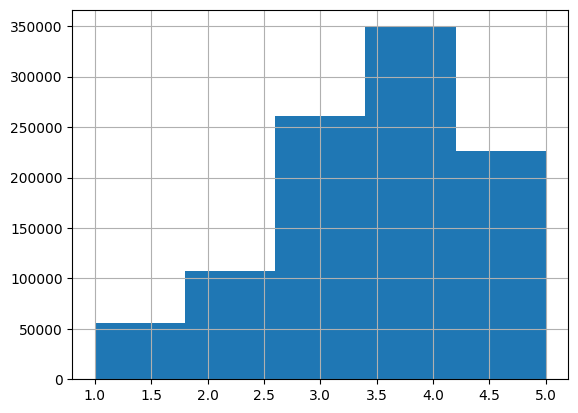

In [12]:
mov_rat['Rating'].hist(bins=5)

Next, let's use join plot to check correlation between the average rating and the number of ratings.
You will notice the upward trend from the scatterplot showing that the pipular movies get the higher ratings.
We will use this strategy for recommender system Method 2.

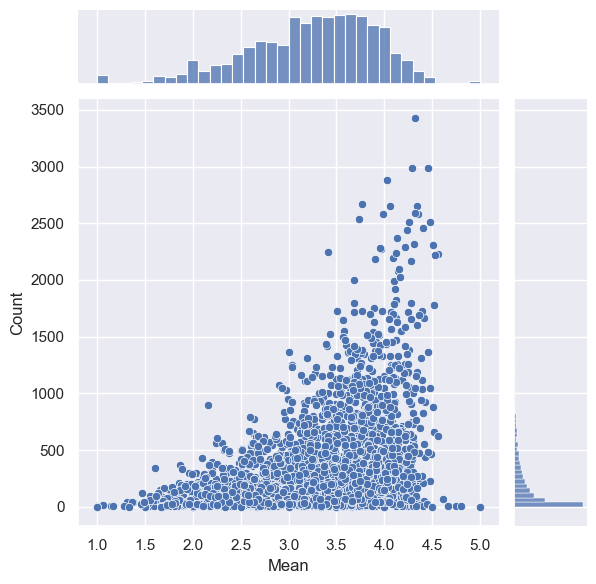

In [13]:
import seaborn as sns
sns.set_theme()
genre_agg= mov_rat[['MovieID','Title_1','Rating']].groupby(['MovieID','Title_1'])['Rating'].agg(Mean='mean', Count='count')
sns.jointplot(data=genre_agg,x="Mean",y="Count")

## Recommender System 1: Method 1-

In [14]:
def recommender1_m1(genre,n=5):
    mov_rat_adv = mov_rat[(mov_rat[genre]==1)]
    mov_rat_adv.reset_index(drop=True,inplace=True)
    genre_grouped= mov_rat_adv[['MovieID','Title_1','Rating']].groupby(['MovieID','Title_1','Rating']).size()
    genre_grouped_df = genre_grouped.to_frame('count').reset_index()
    genre_rating = genre_grouped_df.pivot(index=['MovieID','Title_1'],columns='Rating',values='count').fillna(0)
    genre_rating.columns=['r1','r2','r3','r4','r5']
    def moviescore(r):
        return r.r1*(-1)+r.r2*(-0.5)+r.r3*(-0.1)+r.r4*(0.5)+r.r5
    genre_rating['score']=genre_rating.apply(moviescore,axis=1)
    return genre_rating.score.nlargest(n=n)

### Top 5 Movies in dataset

In [15]:
GENRE_FOR_RECOMMENDATION=total_genres[2]
print(f"Recommendation for : {GENRE_FOR_RECOMMENDATION}")
recommender1_m1(genre=GENRE_FOR_RECOMMENDATION,n=5)

Recommendation for : Animation


MovieID  Title_1                 
1        Toy Story                   1156.5
3114     Toy Story 2                  944.6
2355     Bug's Life, A                686.8
1148     Wrong Trousers, The          660.2
2987     Who Framed Roger Rabbit?     562.1
Name: score, dtype: float64

## Recommender System 1: Method 2-

In [16]:
def recommender1_m2(genre,n=5,min_count=100):
    mov_rat_adv = mov_rat[(mov_rat[genre]==1)]
    mov_rat_adv.reset_index(drop=True,inplace=True)
    genre_agg= mov_rat_adv[['MovieID','Title_1','Rating']].groupby(['MovieID','Title_1'])['Rating'].agg(Mean='mean', Count='count')
    genre_agg_filtered = genre_agg[genre_agg['Count']>min_count].reset_index()
    genre_agg_filtered.sort_values(by="Mean", ascending=False,inplace=True)
    return genre_agg_filtered.head(n)

GENRE_FOR_RECOMMENDATION=total_genres[2]
print(f"Recommendation for : {GENRE_FOR_RECOMMENDATION}")
recommender1_m2(genre=GENRE_FOR_RECOMMENDATION,min_count=100,n=5)

Recommendation for : Animation


,MovieID,Title_1,Mean,Count
16,745,"Close Shave, A",4.520548,657
27,1148,"Wrong Trousers, The",4.507937,882
14,720,Wallace & Gromit: The Best of Aardman Animation,4.426941,438
29,1223,"Grand Day Out, A",4.361522,473
75,3429,Creature Comforts,4.335766,274


## Recommender System 2

In [17]:
import implicit
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler

In [18]:
model = implicit.als.AlternatingLeastSquares(factors=50,iterations=15)

In [19]:
data= mov_rat[["MovieID","UserID","Rating"]]

In [20]:
data['MovieID']=data['MovieID'].astype("category")
data['UserID']=data['UserID'].astype("category")
data['MovieID'] = data['MovieID'].cat.codes
data['UserID'] = data['UserID'].cat.codes

/var/folders/qd/tg9lj7vj279dq94pqm2rj3n80000gn/T/ipykernel_39843/2341438274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MovieID']=data['MovieID'].astype("category")
/var/folders/qd/tg9lj7vj279dq94pqm2rj3n80000gn/T/ipykernel_39843/2341438274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['UserID']=data['UserID'].astype("category")
/var/folders/qd/tg9lj7vj279dq94pqm2rj3n80000gn/T/ipykernel_39843/2341438274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [35]:
sparse_item_user = sparse.csr_matrix((data['Rating'].astype(int), (data['MovieID'], data['UserID'])))
sparse_user_item = sparse.csr_matrix((data['Rating'].astype(int), (data['UserID'], data['MovieID'])))

In [89]:
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)
alpha_val = 15
data_conf = (sparse_user_item * alpha_val).astype('int')
model.fit(data_conf)

  0%|          | 0/20 [00:00<?, ?it/s]

In [141]:
n_similar = 10

### User Based Collaborative Filtering (UBCF) Method 1:

In [143]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 2025
user_id = 501

# Use the implicit recommender.
similar = model.recommend(user_id,user_items=sparse_user_item[user_id],N=n_similar)
recommendations = pd.DataFrame({'movies': similar[0], 'score': similar[1]})
recommendations

,movies,score
0,2651,1.035475
1,1120,0.995389
2,346,0.993373
3,802,0.983468
4,2203,0.967768
5,253,0.956292
6,851,0.953745
7,1108,0.951671
8,593,0.948745
9,1106,0.945146


In [144]:
mov_rat[mov_rat.UserID==501][["MovieID","Rating"]]

,MovieID,Rating
2818,3,3
28071,70,3
34256,110,5
40511,144,4
73777,277,4
...,...,...
998144,3938,2
998170,3939,1
998210,3941,1
998233,3942,1


### Item Based Collaborative Filtering (UBCF) Method 2:

In [145]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------

# Find the 10 most similar
item_id = 100
# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)
recommendations = pd.DataFrame({'movies': similar[0], 'score': similar[1]})
recommendations

,movies,score
0,100,1.000000
1,1323,0.912695
2,449,0.908922
3,408,0.879725
4,2389,0.856539
5,3249,0.854606
6,1030,0.835951
7,384,0.834199
8,2573,0.831100
9,194,0.824983
